In [1]:
#import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

In [2]:
#import dataset
turbine_df = pd.read_csv("gas_turbines.csv")
turbine_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


## EDA

In [3]:
#Check for NA values
turbine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


### No Na values in the dataset

In [4]:
#check for duplicate rows
turbine_df[turbine_df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


### No duplicate sets in the dataste

In [5]:
#descriptive statistics
turbine_df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


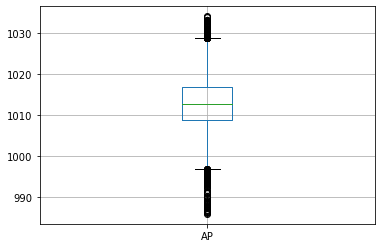

In [6]:
#check for outliers
turbine_df.boxplot(column=["AP"]);

###  AT has no outliers
###  AP outliers below 990 and above 1030
###  AH has no outliers
###  AFDP outliers above 6.8
###  GTEP outliers above 35
###  TIT outliers below 1030
###  TAT outliers below 525
###  CO outliers above 20

In [7]:
#delete outliers
turbine_df_eda = turbine_df.drop(turbine_df[(turbine_df["AP"] < 990) | (turbine_df["AP"] > 1030)].index, axis=0)
turbine_df_eda = turbine_df_eda.drop(turbine_df_eda[(turbine_df_eda["AFDP"] > 6.8)].index, axis=0)
turbine_df_eda = turbine_df_eda.drop(turbine_df_eda[(turbine_df_eda["GTEP"] > 35)].index, axis=0)
turbine_df_eda = turbine_df_eda.drop(turbine_df_eda[(turbine_df_eda["TIT"] < 1030)].index, axis=0)
turbine_df_eda = turbine_df_eda.drop(turbine_df_eda[(turbine_df_eda["TAT"] < 525)].index, axis=0)
turbine_df_eda = turbine_df_eda.drop(turbine_df_eda[(turbine_df_eda["CO"] > 20)].index, axis=0)

turbine_df_eda.reset_index(drop = True, inplace = True)

In [8]:
# Data transformation
turbine_df_std = StandardScaler().fit_transform(turbine_df_eda)

In [9]:
#Data splitting
x = np.concatenate((turbine_df_std[:,0:7], turbine_df_std[:,8:]), axis=1)
y = turbine_df_std[:,8]

In [10]:
#Splitting train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [11]:
x_train.shape

(10265, 10)

## Model

In [12]:
#create function for parameter tuning
def create_model(neuron1, init, activation_function, dropout_rate, neuron2, learning_rate):
    model = Sequential()
    model.add(Dense(neuron1, input_dim=10, kernel_initializer=init, activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2, kernel_initializer = init, activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation = "linear"))
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer = adam, metrics = ["mean_absolute_error"])
    return model

In [14]:
#model creation
model1 = KerasRegressor(build_fn=create_model, verbose=0)

#parameters for grid
batch_size = [10,20,50]
epochs = [10]#[10,50,100]
learning_rate = [0.001, 0.01, 0.1]
neuron1 = [10,15,25]
init = ["normal", "uniform"]
activation_function = ["relu", "linear","leakyrelu"]
dropout_rate = [0.0, 0.1, 0.2]
neuron2 = [10, 15, 20]

#dictionary for gridsearch
para_grid = dictpara_grid = dict(batch_size = batch_size, epochs = epochs, learning_rate = learning_rate, 
                                 dropout_rate = dropout_rate, activation_function = activation_function, 
                                 init = init, neuron1 = neuron1, neuron2 = neuron2)

#Build gridsearch and fit
gsv = GridSearchCV(estimator=model1, param_grid=para_grid, verbose=10)
gsv.fit(x_train, y_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.008, total=   3.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.006, total=   6.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.010, total=   6.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.009, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.7s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.004, total=   7.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.9s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.007, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   36.3s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.009, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   42.7s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.009, total=   6.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   49.5s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.008, total=   7.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   56.7s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.005, total=   7.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.010, total=   6.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.009, total=   6.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.007, total=   6.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.007, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.010, total=   6.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.017, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.019, total=   6.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.014, total=   6.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.119, total=   8.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.172, total=   7.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.149, total=   7.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.140, total=   6.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.120, total=   7.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.086, total=   6.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.007, total=   6.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.010, total=   6.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.009, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.008, total=  12.0s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.005, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.017, total=  11.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, ne

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.019, total=  12.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.015, total=  12.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.028, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.062, total=  11.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.075, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.064, total=  11.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.143, total=  11.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.075, total=  12.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.134, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.044, total=  11.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.121, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.068, total=  12.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.094, total=  11.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.097, total=  11.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.048, total=  11.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.137, total=  11.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.140, total=  12.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.054, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.242, total=  11.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.276, total=  12.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.134, total=  11.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.471, total=  12.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.076, total=  10.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.085, total=  11.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, n

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.039, total=  10.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.047, total=  10.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.037, total=  12.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.117, total=  11.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.089, total=  11.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.057, total=  11.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.088, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.096, total=  12.0s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.059, total=  12.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.287, total=  11.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.471, total=  11.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.227, total=  12.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.128, total=  11.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.096, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.114, total=  11.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.072, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.111, total=  12.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.033, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.078, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.224, total=  11.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.149, total=  10.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.082, total=  12.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.100, total=  12.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.456, total=  11.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neur

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.504, total=  12.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.477, total=  11.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.504, total=  12.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.106, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.119, total=   6.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.084, total=   6.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.042, total=   6.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.076, total=   6.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.052, total=   6.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.060, total=   6.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.146, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.157, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.249, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.555, total=   5.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.591, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, 

[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.532, total=   6.5s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.758, total=   6.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.474, total=   6.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.006, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.006, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.007, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.007, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.007, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.010, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=1

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.026, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.015, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.016, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.075, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.068, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.109, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.084, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.051, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.058, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.005, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.006, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.007, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.011, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.019, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.021, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.015, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.021, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.011, total=   3.8s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.058, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.051, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.120, total=   3.9s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.147, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.048, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.063, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.080, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.062, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.054, total=   3.8s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.120, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.127, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.083, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.064, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.039, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.081, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=25, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.227, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.191, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.297, total=   3.9s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.083, total=   3.8s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.066, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.064, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.065, total=   4.1s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.027, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.043, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.067, total=   6.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.110, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.058, total=   3.8s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.213, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.128, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.173, total=   3.9s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.266, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.122, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.268, total=   4.0s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.101, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.101, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.113, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.030, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.059, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.043, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.080, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.073, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.155, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.501, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.291, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.378, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.458, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.290, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.447, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.086, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.057, total=   3.8s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.088, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.196, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.098, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.079, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.066, total=   3.5s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.072, total=   3.7s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.127, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.460, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.471, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.265, total=   3.2s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, 

[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.237, total=   3.3s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.350, total=   3.6s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.281, total=   3.4s
[CV] activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.011, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.008, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.012, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.017, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.014, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.028, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.011, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.015, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.021, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.052, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.052, total=   2.2s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.067, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.017, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.020, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.014, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.011, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.008, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.008, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.008, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.014, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.013, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.013, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.021, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.014, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.060, total=   2.2s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.067, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.101, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.083, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.072, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.074, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.052, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.039, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.043, total=   2.0s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.077, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.045, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.087, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.147, total=   2.1s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.216, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.185, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.209, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.169, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.163, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.083, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.052, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.047, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.036, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.024, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.044, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.108, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.104, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.041, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.128, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.074, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.188, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.202, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.226, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.214, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.070, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.078, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.090, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.143, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.120, total=   2.0s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.090, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.091, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.075, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.074, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, 

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.307, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.305, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.107, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.212, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.308, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.286, total=   2.0s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.055, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.071, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.042, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.190, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.123, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.056, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.108, total=   1.9s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.133, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.075, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuro

[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.439, total=   1.8s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.281, total=   1.6s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.215, total=   1.7s
[CV] activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=relu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, 

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.002, total=   5.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.008, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.005, total=   5.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.006, total=   6.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.006, total=   6.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.007, total=   6.1s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.017, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.018, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.009, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.013, total=   5.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.018, total=   6.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.007, total=   5.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.109, total=   6.1s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.052, total=   6.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.050, total=   5.6s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.006, total=   5.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.004, total=   5.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.007, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.005, total=   6.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.010, total=   5.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.006, total=   5.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.009, total=   5.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.018, total=   5.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.009, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.057, total=   5.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.057, total=   4.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.148, total=   5.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.061, total=   5.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.085, total=   5.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.123, total=   5.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.021, total=   5.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.064, total=   5.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.055, total=   5.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.011, total=   5.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.033, total=   5.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.011, total=   5.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.039, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.116, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.025, total=  12.1s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.455, total=  11.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.489, total=  12.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.256, total=  11.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.439, total=  12.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.508, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.267, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.072, total=  11.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.044, total=  12.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.042, total=  11.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.022, total=  12.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.069, total=  11.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.033, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_r

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.040, total=   8.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.044, total=  11.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.078, total=   9.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.745, total=  12.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.283, total=  11.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.413, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.528, total=  11.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.855, total=  11.6s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.986, total=  12.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.036, total=  12.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.044, total=  12.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.035, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.045, total=  11.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.043, total=  11.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.066, total=  11.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.071, total=  12.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.083, total=  11.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.131, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.747, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.436, total=  12.2s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.403, total=  11.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.345, total=  12.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=-2.588, total=  12.4s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.050, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.012, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.042, total=  12.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.070, total=  12.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.028, total=  12.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.116, total=  11.5s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.015, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.078, total=  12.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.193, total=  12.0s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.074, total=  11.8s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.473, total=  11.3s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.655, total=  11.9s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-1.644, total=  11.7s
[CV] activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.002, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.003, total=   6.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.004, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.002, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.006, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.002, total=   6.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.011, total=   3.5s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.006, total=   7.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.008, total=   6.4s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.029, total=   6.4s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.014, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.018, total=   7.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, 

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.056, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.165, total=   7.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.028, total=   6.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.003, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.005, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.004, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.002, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.003, total=   7.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.004, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.014, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.026, total=   6.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.008, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.044, total=   5.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.081, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.069, total=   5.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.068, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.059, total=   6.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.088, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.030, total=   6.5s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.027, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.029, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.022, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.025, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.029, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.048, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.056, total=   7.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.114, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.397, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.229, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.167, total=   6.5s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.176, total=   6.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.161, total=   7.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.329, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.057, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.024, total=   6.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.016, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.036, total=   5.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.035, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.072, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.044, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.063, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.055, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.203, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.147, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.231, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.407, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.280, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.496, total=   6.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.072, total=   6.4s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.016, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.019, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.035, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.051, total=   6.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.038, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.083, total=   6.2s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.056, total=   7.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.124, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.208, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.252, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.163, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.057, total=   6.5s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.052, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.030, total=   6.6s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.022, total=   7.0s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.067, total=   6.8s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.022, total=   6.7s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.122, total=   6.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.046, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.062, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.042, total=   7.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.049, total=   6.4s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.040, total=   6.9s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.321, total=   6.1s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.652, total=   7.3s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.209, total=   6.4s
[CV] activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.005, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.005, total=   2.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=-0.003, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.003, total=   3.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.004, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.003, total=   3.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.030, total=   3.9s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.021, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.014, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.011, total=   3.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.077, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.032, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neur

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.027, total=   3.1s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.057, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.467, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.003, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.004, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=-0.005, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.002, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=15, score=-0.004, total=   3.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.007, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.009, total=   3.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.018, total=   3.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=-0.010, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=-0.053, total=   3.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.088, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.043, total=   3.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.055, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.035, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=-0.021, total=   3.3s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.030, total=   3.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.033, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=-0.023, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.010, total=   3.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=-0.014, total=   4.1s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.029, total=   3.3s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.039, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.021, total=   3.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=-0.066, total=   3.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=-0.139, total=   3.1s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.138, total=   4.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.181, total=   3.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.221, total=   1.9s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.116, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=-0.132, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.027, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.037, total=   1.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=-0.043, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.030, total=   1.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=-0.043, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.069, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.103, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.035, total=   1.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=-0.021, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=-0.087, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.135, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.118, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.429, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.067, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=-0.226, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.0

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.011, total=   2.0s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.037, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=-0.017, total=   1.8s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.029, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=-0.020, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.035, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.089, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.120, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15, score=-0.031, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=-0.115, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.293, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.158, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuro

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.044, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.026, total=   1.3s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=10, score=-0.051, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.042, total=   1.7s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.062, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=-0.058, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.027, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=-0.067, total=   1.3s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=-0.048, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.035, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.042, total=   1.6s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=-0.110, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_ra

[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=-0.329, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.161, total=   1.4s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=-0.117, total=   1.5s
[CV] activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=linear, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1

C:\Users\praing57504\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\praing57504\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\praing57504\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 157, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipython-input-12-4848de13f233>", line 4, in create_model
    model.add(Dense(neuron1, input_dim=10, kernel_initializer=init, activation = activation_function))
  File "C:\Users\praing57504\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1161, in __init__
    self.activation = activations.get(activation)
  File "C:\Users\praing57504\A

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=10, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_ra

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, lea

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=20, dropout_rate=0.2, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learning_rate=0.1, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.0, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.001, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rate=0.1, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.01, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learning_rate=0.1, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.1, epochs=10, init=uniform, learn

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.001, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, 

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.01, neuron1=25, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learni

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rate=0.1, neuron1=15, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=normal, learning_rat

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=10, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=un

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.001, neuron1=25, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=10, neuron2=10 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=unifo

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=10, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.01, neuron1=25, neuron2=15 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform,

[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=15, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20, score=nan, total=   0.0s
[CV] activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learning_rate=0.1, neuron1=15, neuron2=20 
[CV]  activation_function=leakyrelu, batch_size=50, dropout_rate=0.2, epochs=10, init=uniform, learn

[Parallel(n_jobs=1)]: Done 7290 out of 7290 | elapsed: 454.0min finished


GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FD9F1A45B0>,
             param_grid={'activation_function': ['relu', 'linear', 'leakyrelu'],
                         'batch_size': [10, 20, 50],
                         'dropout_rate': [0.0, 0.1, 0.2], 'epochs': [10],
                         'init': ['normal', 'uniform'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'neuron1': [10, 15, 25], 'neuron2': [10, 15, 20]},
             verbose=10)

In [ ]:
gsv.best_score_, gsv.best_params_

In [ ]:
#Best parameters
# (-0.0024959429865702987,
#  {'activation_function': 'linear',
#   'batch_size': 20,
#   'dropout_rate': 0.0,
#   'epochs': 10,
#   'init': 'normal',
#   'learning_rate': 0.001,
#   'neuron1': 10,
#   'neuron2': 15})

In [21]:
#Final model with parameters
model_final = Sequential()
model_final.add(Dense(10, input_dim=10, kernel_initializer="normal", activation = "linear"))
model_final.add(Dense(15, kernel_initializer = "normal", activation = "linear"))
model_final.add(Dense(2, activation = "linear"))

adam = Adam(learning_rate=0.001)
model_final.compile(loss="mean_absolute_error", optimizer = adam, metrics = ["mean_absolute_error"])

In [53]:
#model score with test data
from sklearn.metrics import mean_absolute_error

model_final.fit(x_train,y_train,batch_size=20,epochs=20, verbose=0)
y_pred = model_final(x_test)

print(np.round(mean_absolute_error(y_test,y_pred[:,0]),4))

0.0014
